In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from glob import glob
from astropy.table import Table
import os
import re
from astropy.visualization import MinMaxInterval, ZScaleInterval, LinearStretch, LogStretch, SqrtStretch, ImageNormalize
from astroscrappy import detect_cosmics
from glob import glob

In [3]:
log = Table.read('KCRM_2023Oct.csv', format = 'csv')
kcrm = log[log['Camera'] == 'RED']

In [4]:
sci_frames = np.arange(67, 172)
# badframe = [127, 128, 129, 130]
base = '/scr/zzhuang/keck_obs/kcwi/2023oct13/red/'
redux = os.path.join(base, 'redux')
# sci_frames = np.arange(117, 120)

In [5]:
# std_fno = np.arange(78, 85)
# for n in std_fno:
#     path = os.path.join(base, f'kr230923_{n:05d}.fits')
#     if not os.path.exists(path):
#         continue
#     data = fits.open(os.path.join(base, f'kr230923_{n:05d}.fits'))
#     data[0].header['OBJECT'] = 'bd28d4211'
#     data.writeto(os.path.join(base, f'kr230923_{n:05d}.fits'), overwrite = True)

In [5]:
obj_dict = {}
for i, row in enumerate(kcrm):
    if not os.path.exists(os.path.join(base, row['No.'])):
        print(os.path.join(base, row['No.']))
        continue
    fno = int(row['No.'][9:-5])
    if (fno in sci_frames) :
        objname = '%s_%i'%(row['Object'], np.round(row['Sky PA']))
        if objname not in obj_dict.keys():
            # print(objname)
            obj_dict[objname] = []
        obj_dict[objname].append(row['No.'])

/scr/zzhuang/keck_obs/kcwi/2023oct13/red/kr231013_00054.fits


In [7]:
obj_dict['G191B2B_300']

['kr231013_00170.fits', 'kr231013_00171.fits']

In [8]:
wavemap_path = glob(os.path.join(redux, '*wavemap.fits'))[0]
wavemap = fits.getdata(wavemap_path)

In [37]:
for obj in list(obj_dict.keys()):
    if 'gal' not in obj and len(obj_dict[obj]) >= 3:
        msci = np.median([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
    else:
        msci = np.min([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
    mhdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', obj_dict[obj][0])))
    mhdu[0].data = msci
    mhdu.writeto(os.path.join(redux, 'int_median', '%s_int.fits'%obj), overwrite = True)
    print('######################%s##############'%obj)
    for f in obj_dict[obj]:
        img_hdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f)))
        img = img_hdu[0].data
        
        ratio = np.median(img[wavemap > 0] / msci[wavemap > 0])

        crs = img - msci
        crmsk = sigma_clip(crs, sigma = 3, maxiters=1, grow=2).mask.astype(float)
        crmsk_surr = sigma_clip(crs, sigma = 3, maxiters=1, grow=10).mask.astype(float)

        idx = np.where((crmsk < 1e-4) & (crmsk_surr > 1e-4) & (wavemap > 0) )
        ratio2 = np.median(img[idx]/msci[idx])
        
        print(ratio, ratio2)

        crmsk_med = crmsk * msci * ratio2
        crmsk_med[crmsk_med < 1e-4] = 0

        primary = fits.PrimaryHDU(crmsk, header=img_hdu[0].header)
        med = fits.ImageHDU(crmsk_med, name='MEDSCI')
        sur = fits.ImageHDU(crmsk_surr, name = 'CRMSK_SUR')
        hdul = fits.HDUList([primary, med, sur])
        hdul.writeto(os.path.join(redux, re.sub('.fits', '_crmsk.fits', f)), overwrite=True)

######################bd_28d4211_0##############
1.0 0.8955371
1.0 1.248801
1.0 1.0
######################gal071_866_0##############
1.0665883 1.0661869
1.0437998 1.0428362
1.0375475 1.0352458
######################gal071_866_sky_0##############
1.0901265 1.0879343
1.071155 1.0666507
1.0598849 1.0521145
######################gal071_866_90##############
1.0310231 1.0289009
1.0488497 1.045248
1.0660174 1.0660825
######################gal058_855_90##############
1.1358184 1.1294658
1.0714294 1.0720206
1.0649741 1.0636659
1.0751623 1.0738764
######################gal058_855_sky_90##############
1.051724 1.0497689
1.0439906 1.0426735
1.0572002 1.053978
######################gal058_855_0##############
1.0645288 1.0630643
1.056757 1.0542074
1.0322223 1.0325104
######################gal089_879_0##############
1.0341694 1.0311944
1.0626165 1.0617409
1.0467722 1.0452362
######################gal089_879_90##############
1.0792667 1.0768219
1.0503943 1.048737
1.0229645 1.0210882
##################

In [9]:
obj = 'G191B2B_300'
if 'gal' not in obj and len(obj_dict[obj]) >= 3:
    msci = np.median([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
else:
    msci = np.min([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
mhdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', obj_dict[obj][0])))
mhdu[0].data = msci
mhdu.writeto(os.path.join(redux, 'int_median', '%s_int.fits'%obj), overwrite = True)
print('######################%s##############'%obj)
for f in obj_dict[obj]:
    img_hdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f)))
    img = img_hdu[0].data

    ratio = np.median(img[wavemap > 0] / msci[wavemap > 0])

    crs = img - msci
    crmsk = sigma_clip(crs, sigma = 3, maxiters=1, grow=2).mask.astype(float)
    crmsk_surr = sigma_clip(crs, sigma = 3, maxiters=1, grow=10).mask.astype(float)

    idx = np.where((crmsk < 1e-4) & (crmsk_surr > 1e-4) & (wavemap > 0) )
    ratio2 = np.median(img[idx]/msci[idx])

    print(ratio, ratio2)

    crmsk_med = crmsk * msci * ratio2
    crmsk_med[crmsk_med < 1e-4] = 0

    primary = fits.PrimaryHDU(crmsk, header=img_hdu[0].header)
    med = fits.ImageHDU(crmsk_med, name='MEDSCI')
    sur = fits.ImageHDU(crmsk_surr, name = 'CRMSK_SUR')
    hdul = fits.HDUList([primary, med, sur])
    hdul.writeto(os.path.join(redux, re.sub('.fits', '_crmsk.fits', f)), overwrite=True)

######################G191B2B_300##############
1.0 1.0
1.2929906 1.1908696


In [12]:
obj = 'gal090_884_0'
if 'gal' not in obj and len(obj_dict[obj]) >= 3:
    msci = np.median([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
else:
    msci = np.min([fits.getdata(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f))) for f in obj_dict[obj]], axis = 0)
mhdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', obj_dict[obj][0])))
mhdu[0].data = msci
mhdu.writeto(os.path.join(redux, 'int_median', '%s_int.fits'%obj), overwrite = True)
print('######################%s##############'%obj)
for f in obj_dict[obj]:
    img_hdu = fits.open(os.path.join(redux, 'int_nocrmsk', re.sub('.fits', '_int.fits', f)))
    img = img_hdu[0].data

    ratio = np.median(img[wavemap > 0] / msci[wavemap > 0])

    crs = img - msci
    crmsk = sigma_clip(crs, sigma = 3, maxiters=1, grow=2).mask.astype(float)
    crmsk_surr = sigma_clip(crs, sigma = 3, maxiters=1, grow=10).mask.astype(float)

    idx = np.where((crmsk < 1e-4) & (crmsk_surr > 1e-4) & (wavemap > 0) )
    ratio2 = np.median(img[idx]/msci[idx])

    print(ratio, ratio2)

    crmsk_med = crmsk * msci * ratio2
    crmsk_med[crmsk_med < 1e-4] = 0

    primary = fits.PrimaryHDU(crmsk, header=img_hdu[0].header)
    med = fits.ImageHDU(crmsk_med, name='MEDSCI')
    sur = fits.ImageHDU(crmsk_surr, name = 'CRMSK_SUR')
    hdul = fits.HDUList([primary, med, sur])
    hdul.writeto(os.path.join(redux, re.sub('.fits', '_crmsk.fits', f)), overwrite=True)

######################gal090_884_0##############
1.0968719 1.0967286
1.0648642 1.0629443
1.0280719 1.0266125


In [ ]:
data['MEDSCI'].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
#making sky file for the image
filelist = []
reglist = []
skylist = []
for obj in list(obj_dict.keys()):
    if 'sky' not in obj and 'gal' in obj:
        skymask = False
        skyfile = None
        for f in obj_dict[obj]:
            fname = re.sub('.fits', '', f)
            
            #adding the file name of a science frame into the list
            filelist.append('%s\n'%f)
            
            #remove the existing _sky.fits
            if os.path.exists(f'{redux}/{fname}_sky.fits'):
                os.remove(f'{redux}/{fname}_sky.fits')
            
            #adding the region file to run the mask sky
            path = os.path.join(redux, re.sub('.fits', '.reg', f))
            if os.path.exists(path):
                reglist.append(f'kcwi_masksky_ds9 {fname}_intf.fits {fname}.reg\n')
            
                skymask = True
                skyfile = f'redux/{fname}_smsk.fits'
                
            if skymask:
                skylist.append(f'{f} {f} {skyfile}\n')
            else:
                skylist.append(f'{f} {f}\n')
            
            
# with open(os.path.join(base, 'objects.list'), 'w') as file1:
#     file1.writelines(filelist)
    
# with open(os.path.join(redux, 'do_masksky.sh'), 'w') as file2:
#     file2.writelines(reglist)
    
# with open(os.path.join(base, 'kcwi.sky'), 'w') as file3:
#     file3.writelines(skylist)
    

In [19]:
import math
import ref_index


In [20]:
def atm_disper(w0, w1, airmass, temperature=10.0, pressure_pa=61100.0,
               humidity=50.0, co2=400.0):
    """

    Calculate atmospheric dispersion at w1 relative to w0

    Args:
        w0 (float): reference wavelength (Angstroms)
        w1 (float): offset wavelength (Angstroms)
        airmass (float): unitless airmass
        temperature (float): atmospheric temperature (C)
        pressure_pa (float): atmospheric pressure (Pa)
        humidity (float): relative humidity (%)
        co2 (float): Carbon-Dioxide (mu-mole/mole)

    """

    # Calculate
    z = math.acos(1.0/airmass)

    n0 = ref_index.ciddor(wave=w0/10., t=temperature, p=pressure_pa,
                          rh=humidity, co2=co2)
    n1 = ref_index.ciddor(wave=w1/10., t=temperature, p=pressure_pa,
                          rh=humidity, co2=co2)

    return 206265.0 * (n0 - n1) * math.tan(z)

In [ ]:
nwave = 6000
waves = 3278.0 + np.arange(nwave) * 1
disp = np.empty(nwave)
for i, wl in enumerate(waves):
    disp[i] = atm_disper(6000, wl, 1.2)

/scr/zzhuang/software/anaconda3/lib/python3.9/site-packages/ref_index.py:481: RuntimeWarning: divide by zero encountered in double_scalars
  S = 1.0 / wave ** 2
/scr/zzhuang/software/anaconda3/lib/python3.9/site-packages/ref_index.py:484: RuntimeWarning: invalid value encountered in double_scalars
  rvs = 1.022e-8 * (w0 + w1 * S + w2 * S ** 2 + w3 * S ** 3)


In [41]:
waves

array([3278., 3279., 3280., ..., 9275., 9276., 9277.])

In [39]:
waves[np.argmin(np.abs(disp - 0.5*(disp[0] + disp[-1])))]

4305.0

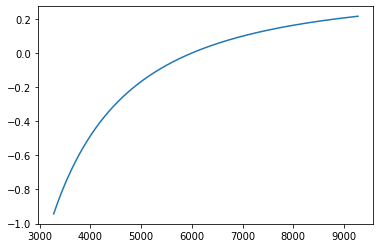

In [40]:
plt.plot(waves, disp)

In [38]:
0.5*(disp[0] + disp[-1])

-0.3637367714368431